In [1]:
from lsdt_dynasim import*

from matplotlib import pyplot as plt
import matplotlib
import numpy as np
import math
from scipy.interpolate import interp1d
  
#########################################################################
##### Beschreibung Programm #############################################
#########################################################################

""" 
Das Programm dient der Berechnung des Systemverhaltens von Schwingungsfähigen Systemen

Bemerkungen:
- Die numerische Berechnung erfolgt mittels Runge Kutta Verfahren (RK4)
- Die Genauigkeit der Ergebnisse hängen von der Zeitschrittweite und der Simulationsdauer ab
- Eine zu kein gewählte Schrittweite führt in der Regel zu einer Energiezufuhr ins System
- Je höher die Steifigkeit des Systems, desto kleiner muss die Simulationsschrittweite gewählt werden
"""
#########################################################################
##### Allgemeine Einstellungen ##########################################
#########################################################################

Bilder_speichern                     = True
CSV_speichern                        = True
CSV_speichern_Blender                = False

#########################################################################
##### Messung einlesen (optional) #######################################
#########################################################################

#########################################################################
##### Simulationsparameter ##############################################
#########################################################################

Input_t_start                        = 0             # Simulationszeit Star
Input_t_ende                         = 10            # Simulationszeit Ende
Input_delta_t                        = 0.0001        # Zeitschrittweite

# Initial and end values
Input_gx                             = 0             # Gravitationsbeschleunigung x-Richtung, Standard: 0
Input_gy                             = 0             # Gravitationsbeschleunigung y-Richtung, Standard: 0
Input_gz                             = -9.81         # Gravitationsbeschleunigung z-Richtung, Standard: -9.81

# Initial and end values
Input_E1_Masse_Masse_m                     = 0.1           # Masse
Input_E2_Masse_Stosszahl_k                 = 0.6           # Stoßzahl (1 = elastisch, 0 = plastisch, 1..0)
        
#########################################################################
##### Anfangsrandbedingungen der Elemente ###############################
#########################################################################

K1_Masse.z   = 10.0

#########################################################################
##### Erstellung aller Elemente #########################################
#########################################################################
"""
Modell:   
    E1_Masse:   Feder    
    E2_Masse:   Elastischer Stoss   
"""

E1_Masse                                = class_DGL_Masse_trans_z_Masse(Input_E1_Masse_Masse_m, Input_gz, [K1_Masse])
E2_Masse                                = class_Elastischer_Stoss_z_Masse(Input_E1_Masse_Masse_m, 999999, Input_E2_Masse_Stosszahl_k, [K1_Masse, K2_Masse])
                 
#########################################################################
##### Start der Simulation ##############################################
#########################################################################

t = Input_t_start
while (t < Input_t_ende):
    # Erst einmal alle Knotenkräfte zu Null setzen, da diese an den Knoten aufsummiert werden
    Reset_Knotenkraefte_Masse()            
                                
    #Berechnung der Kräfte an den Federn und Dämpfern
    #    für alle Elemente
    E1_Masse.Berechnung_Kraefte()    
    E2_Masse.Berechnung_Kraefte()    
    
    #Berechung der massebehafteten Elemente  
    #    nur für Elemente mit Masse
    E1_Masse.Loesung_Differentialgleichung_Zeitschritt(Input_delta_t)                
    
    #Berechnung Energien    
    #    für alle Elemente
    E1_Masse.Berechnung_Energien(Input_delta_t)                
    E2_Masse.Berechnung_Energien(Input_delta_t)                
    
    # Datenlogger Knoten
    Datenlogger_Knoten_schreiben_Masse(t)
    
    #Datenlogger Elemente
    #    für alle Elemente
    datenlogger_E1_Masse.Werte_anhaengen(E1_Masse)                            
    datenlogger_E2_Masse.Werte_anhaengen(E2_Masse)                            
                          
    t = t + Input_delta_t

if (CSV_speichern == True):
    csv_schreiben_Masse('../output_csv/lsdt_dynasim_fall_auf_tischplatte.csv',datenlogger_K1_Masse)
    
if (CSV_speichern_Blender == True):
    csv_schreiben_Masse('../output_csv_blender/lsdt_dynasim_fall_auf_tischplatte_K1.csv',datenlogger_K1_Masse)

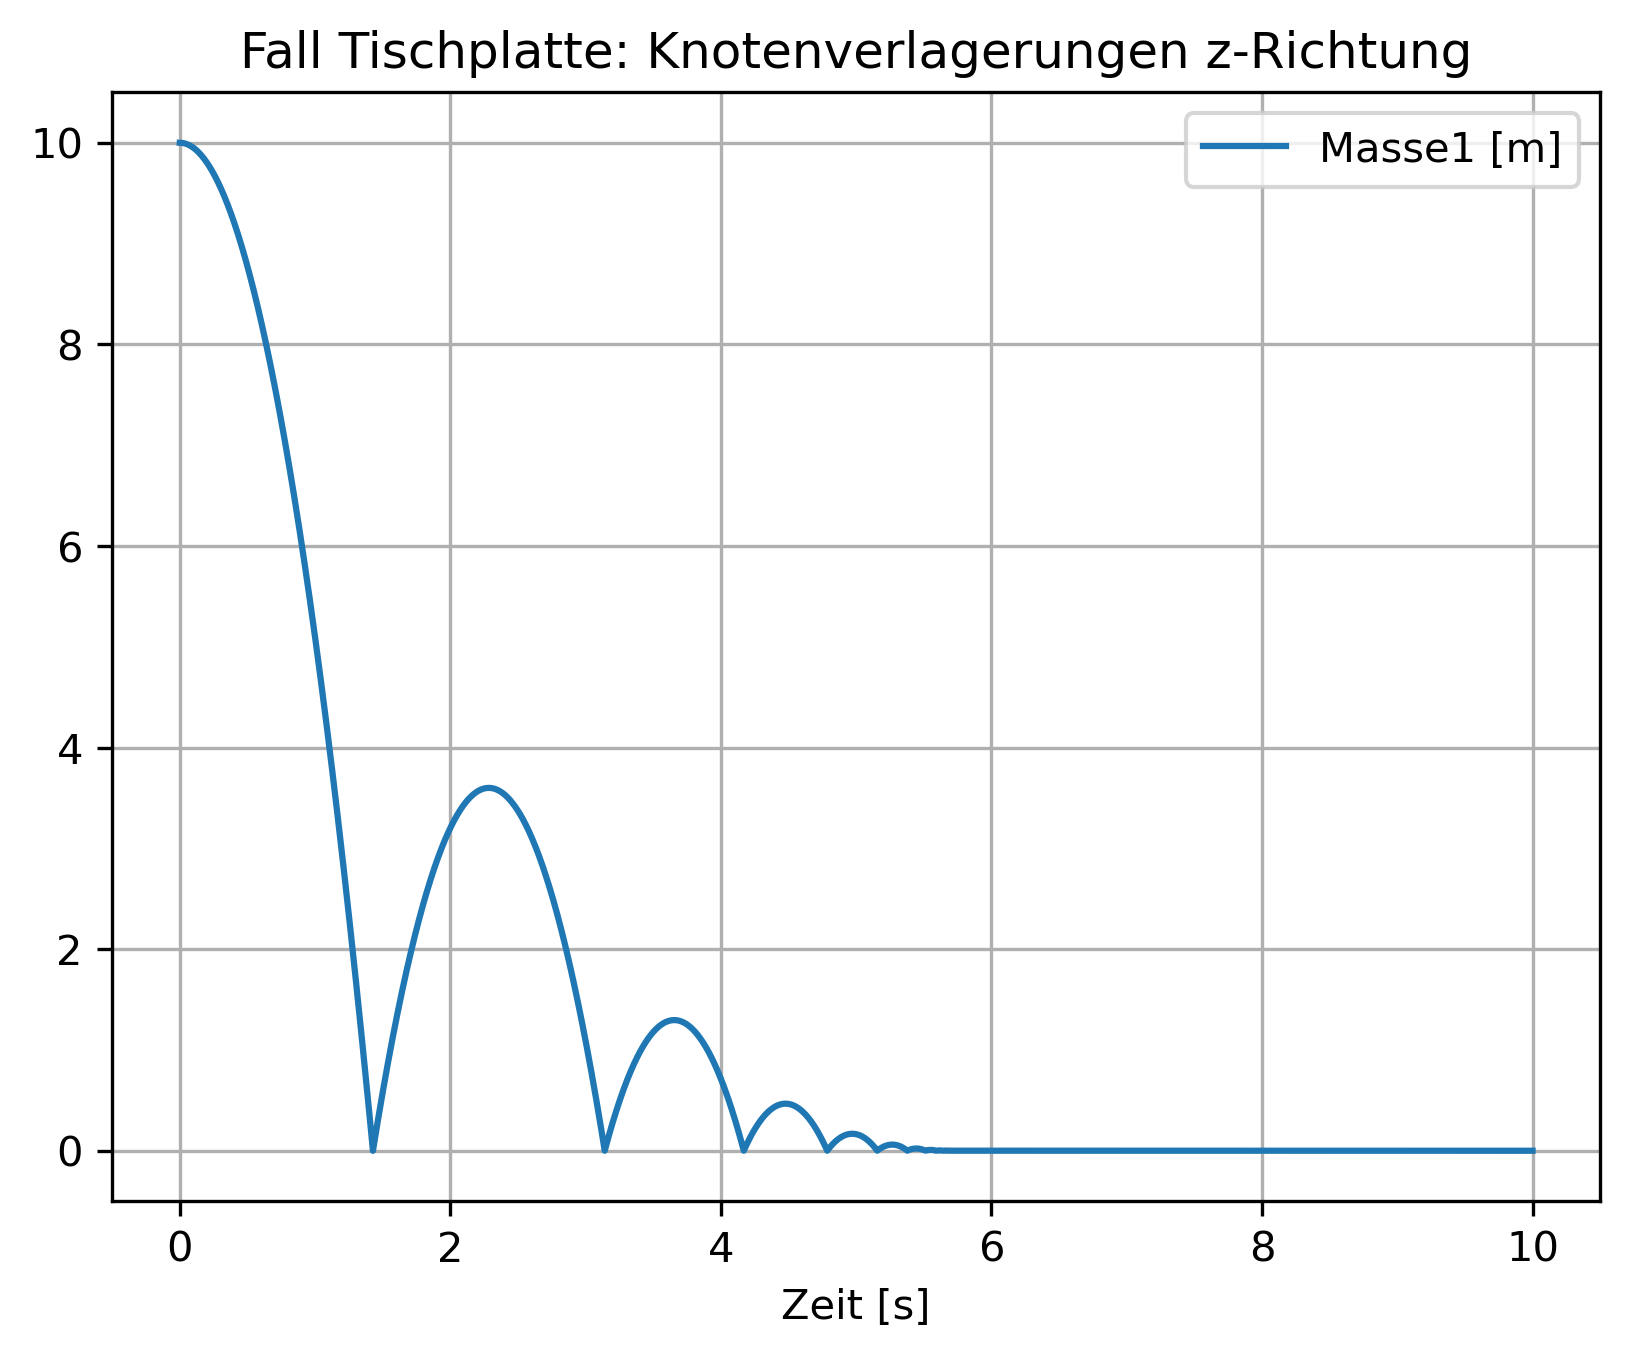

In [2]:
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.title('Fall Tischplatte: Knotenverlagerungen z-Richtung')
plt.plot(datenlogger_t_Masse,datenlogger_K1_Masse.z,label='Masse1 [m]')
#plt.xlim(0,20)
plt.xlabel('Zeit [s]')
plt.grid(True)
plt.legend()
if (Bilder_speichern == True):
    plt.savefig('../output_bilder/lsdt_dynasim_fall_auf_tischplatte1.png')

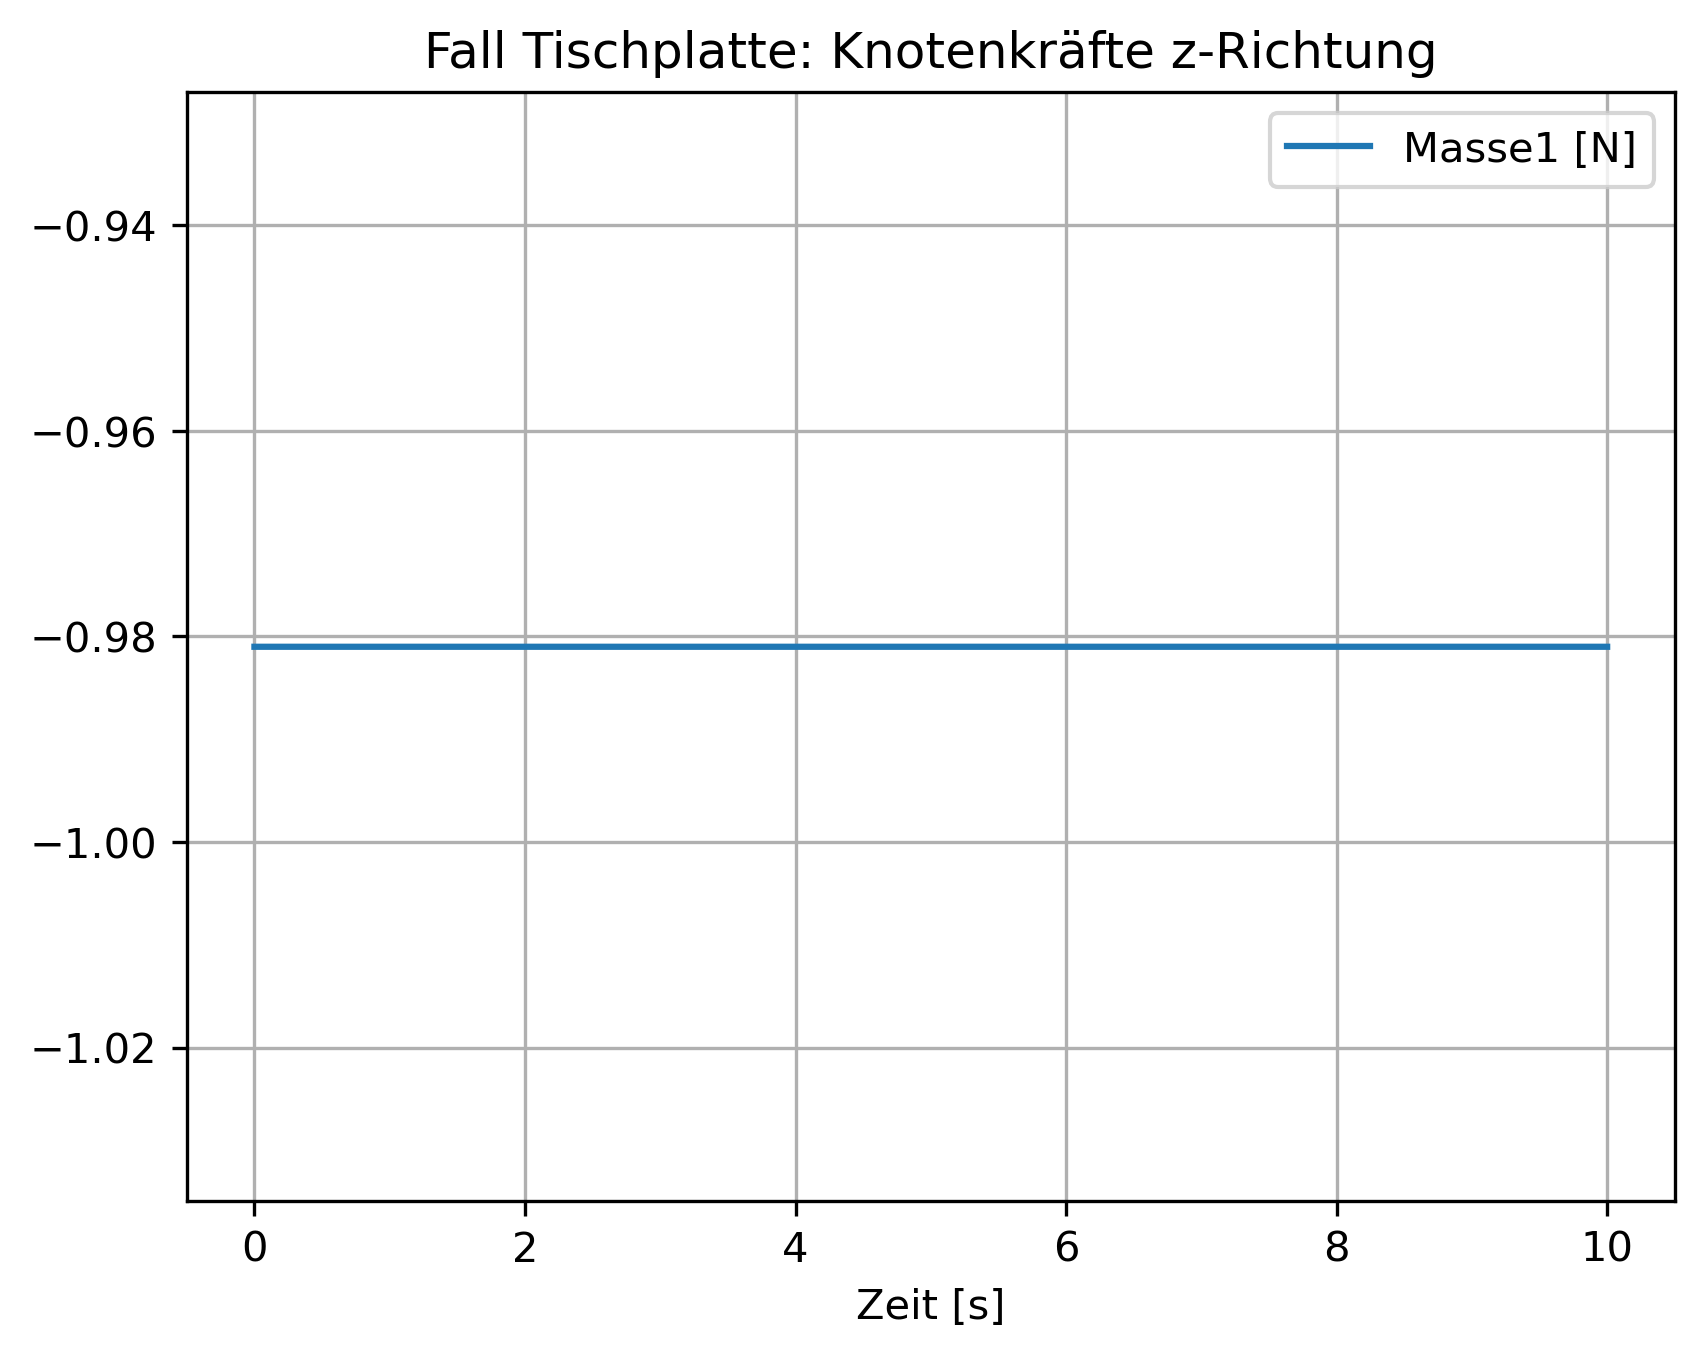

In [3]:
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.title('Fall Tischplatte: Knotenkräfte z-Richtung')
plt.plot(datenlogger_t_Masse,datenlogger_K1_Masse.F_z,label='Masse1 [N]')
#plt.xlim(0,20)
plt.xlabel('Zeit [s]')
plt.grid(True)
plt.legend()
if (Bilder_speichern == True):
    plt.savefig('../output_bilder/lsdt_dynasim_fall_auf_tischplatte2.png')

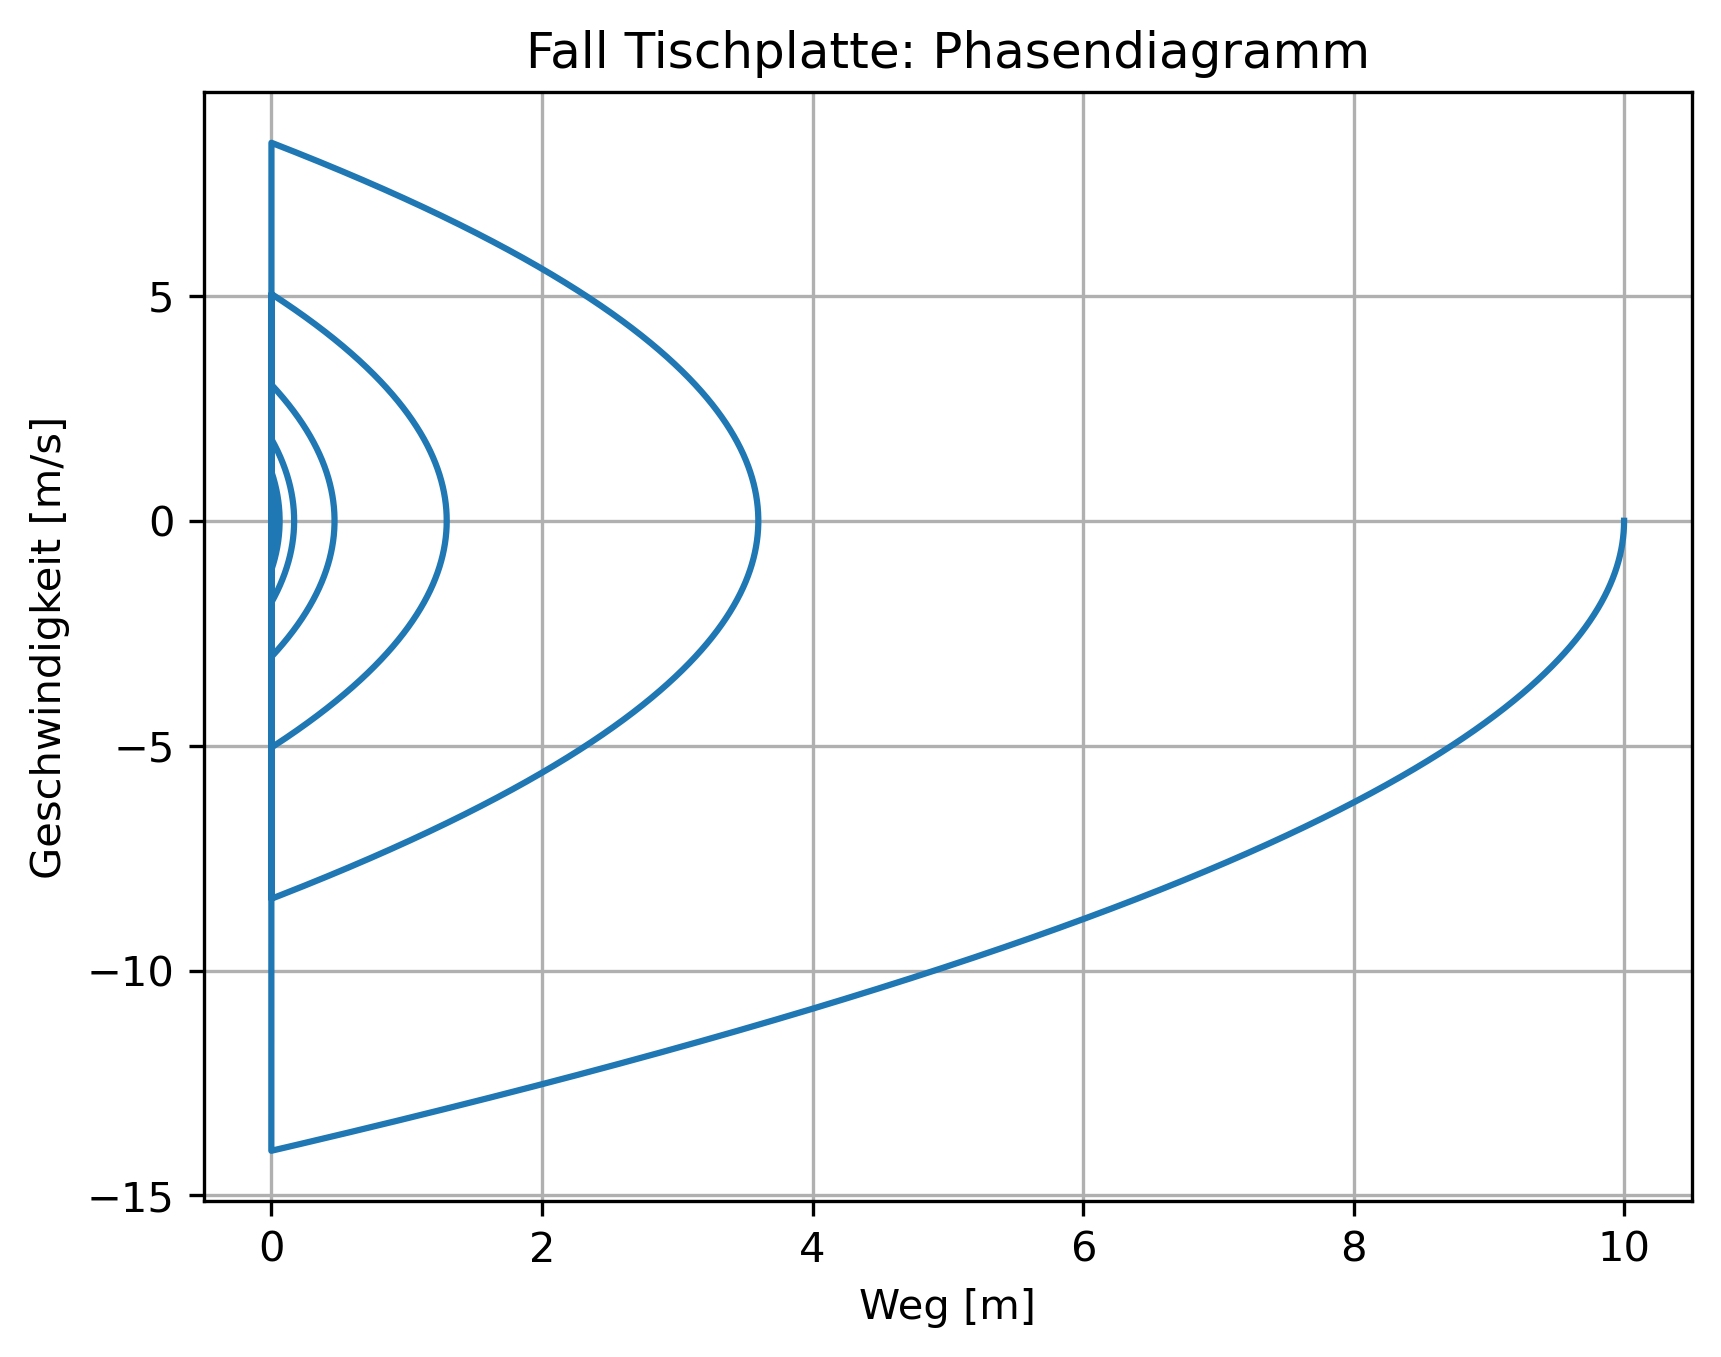

In [4]:
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.title('Fall Tischplatte: Phasendiagramm')
plt.plot(datenlogger_K1_Masse.z,datenlogger_K1_Masse.z_p,label='Masse1 [N]')
#plt.xlim(0,20)
plt.xlabel('Weg [m]')
plt.ylabel('Geschwindigkeit [m/s]')
#plt.legend()
plt.grid(True)
if (Bilder_speichern == True):
    plt.savefig('../output_bilder/lsdt_dynasim_fall_auf_tischplatte3.png')

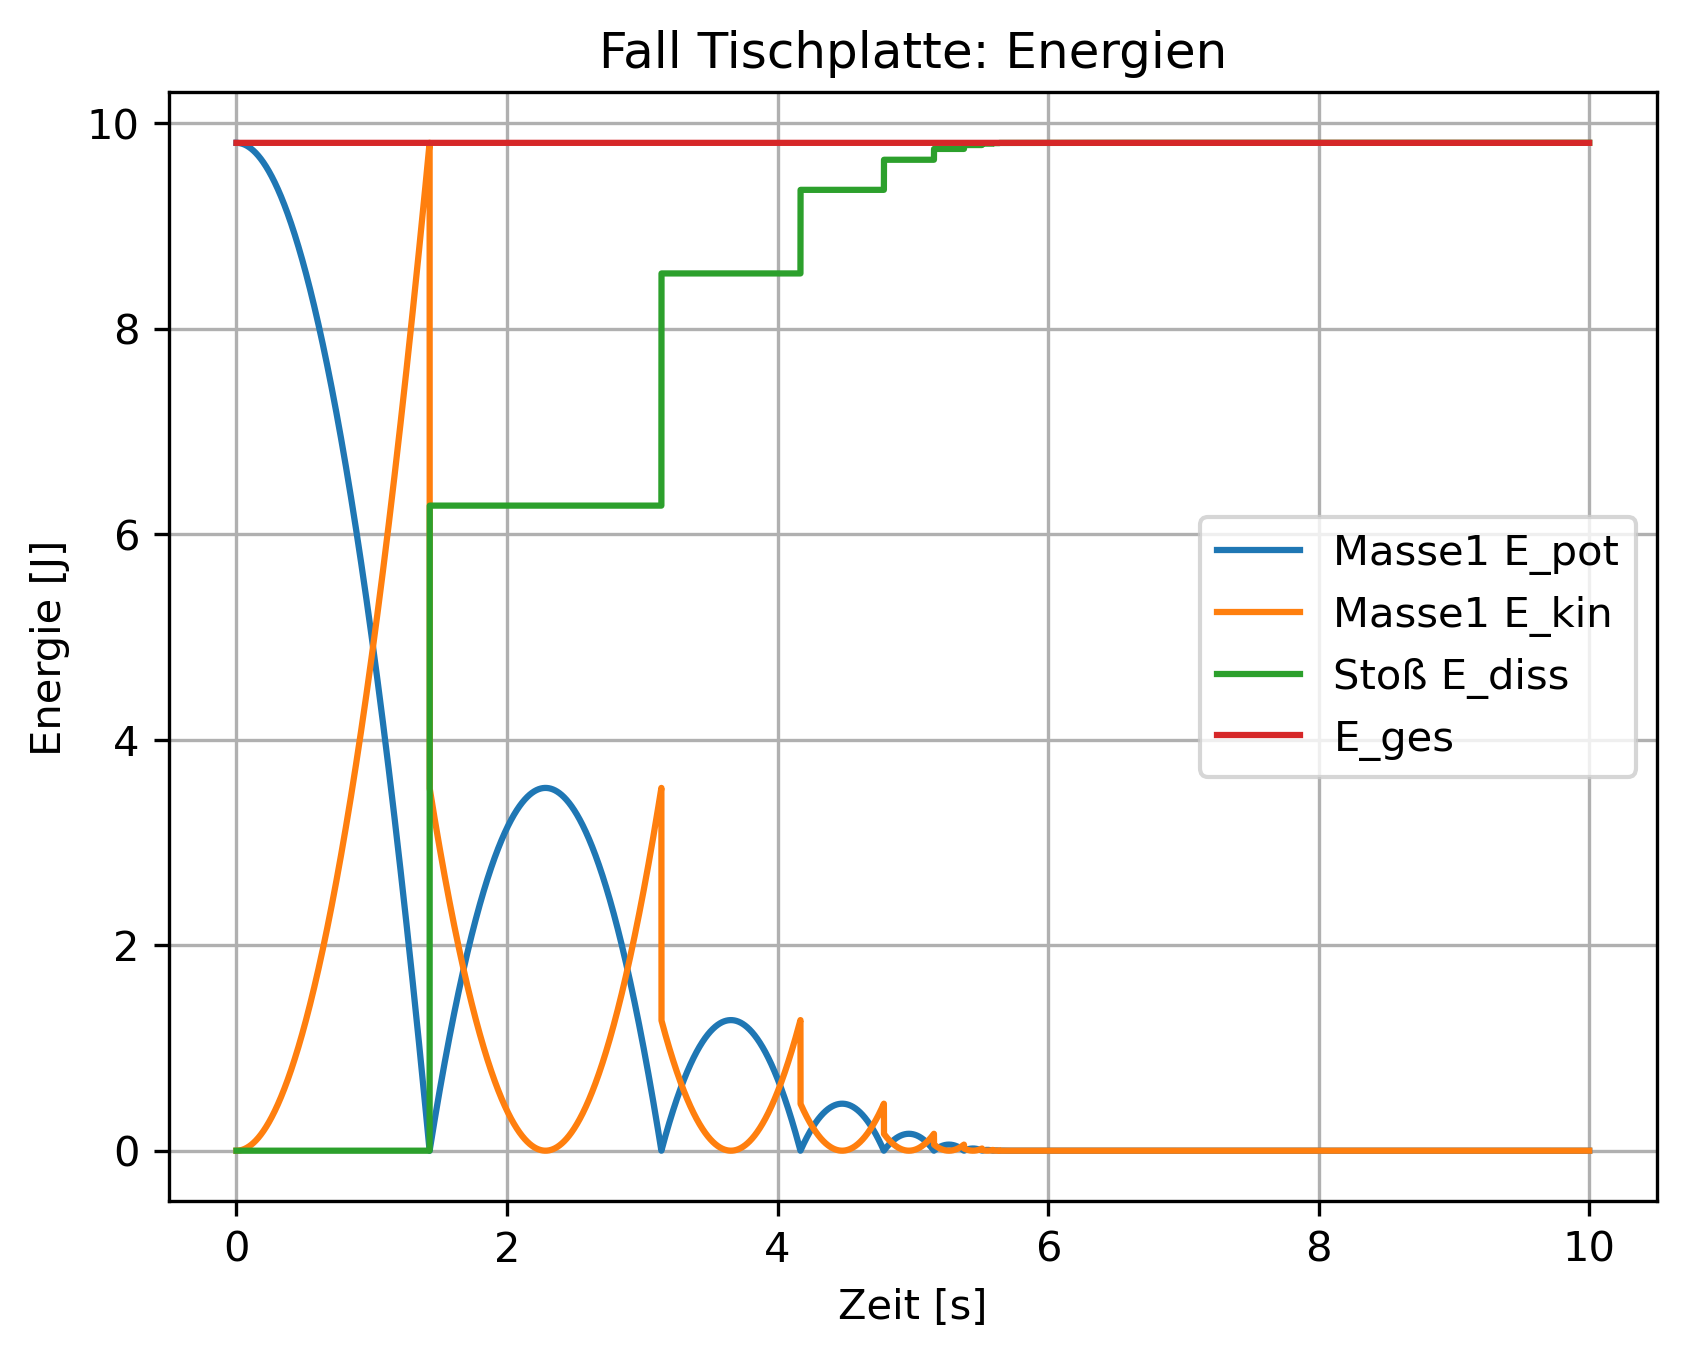

In [5]:
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.title('Fall Tischplatte: Energien')
E_ges = []
for point in range(len(datenlogger_E1_Masse.E_pot)):
    E_ges.append(datenlogger_E1_Masse.E_kin[point] + datenlogger_E1_Masse.E_pot[point] + datenlogger_E2_Masse.E_diss[point])    
plt.plot(datenlogger_t_Masse,datenlogger_E1_Masse.E_pot,label='Masse1 E_pot')
plt.plot(datenlogger_t_Masse,datenlogger_E1_Masse.E_kin,label='Masse1 E_kin')
plt.plot(datenlogger_t_Masse,datenlogger_E2_Masse.E_diss,label='Stoß E_diss')
plt.plot(datenlogger_t_Masse,E_ges,label='E_ges')
#plt.xlim(0,20)
plt.xlabel('Zeit [s]')
plt.ylabel('Energie [J]')
plt.grid(True)
plt.legend()
if (Bilder_speichern == True):
    plt.savefig('../output_bilder/lsdt_dynasim_fall_auf_tischplatte4.png')